# An introduction to ZCA-sphering

In this short post we describe *Zero Phase Component Analysis Sphering* - or *ZCA sphering* for short.  ZCA sphering is a popular *input-normalization* technique akin [standard normalization](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html) and [PCA-sphering](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_5_PCA_sphereing.html), but made especially for image, video, and other naturally ordered data types (here we will focus on its application to image-based data.  As with these other input-normalization schemes, when properly applied ZCA-sphering conditions data in such a way as to substantially accelerate the training of supervised and unsupervised learners (and convolutional networks in general).  Note: this post assumes 

- basic familiarity with edge-based feature extractors (like e.g., convolutional networks or even [basic edge-based histogram features](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_2_Histogram.html)) - i.e., that you understand the importance of extracting edge information from images for un/supervised learning tasks involving image data

- familiarity with [standard normalization](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html) and [PCA-sphering](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_5_PCA_sphereing.html) techniques

You can skip around this document to particular subsections via the hyperlinks below.

-  [Contrast normalization](#contrast-normalization)
-  [Introducing unwanted edges with typical input normalizers](#unwanted-edges)
-  [What went wrong with PCA-sphering?](#PCA-sphereing)
-  [ZCA-sphering](#ZCA-sphereing)
-  [Python implementation](#python-implementation)

In [ ]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from demo_libraries import zca_sphering_library as zcalib
demo = zcalib.normalizers.Tools()

# import standards
import numpy as np
from scipy.stats import ortho_group  

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

<a id='contrast-normalization'></a>
## Contrast normalization

Before discussing ZCA-sphering lets talk about *contrast normalization*.  Contrast normalization is a standard pre-processing technique applied to almost all image-based datasets which simply involves *[standard normalizing](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html) each image in a dataset*, that is subtracting its mean (pixel) value and dividing off its standard deviation.  This helps adjust for *contrast differences* in the various images in a dataset and virtually always done prior to any *feature-wise normalization technique* like ZCA sphering.

Why normalize the image contrast first?  Because we almost never want an image-based learner to be sensitive to contrast, since this would make natural image based learning tasks like e.g., object detection much more difficult to solve (see e.g., the simple [example described in Figure 4.26](https://github.com/jermwatt/machine_learning_refined/blob/gh-pages/sample_chapters/1st_ed/chapter_4.pdf) of the first edition of our textbook).  In other words, contrast normalization helps our learners treat all images equally by normalizing their average intensity.  Below we show an example image on the left and its contrast normalized version on the right.

<IPython.core.display.Javascript object>


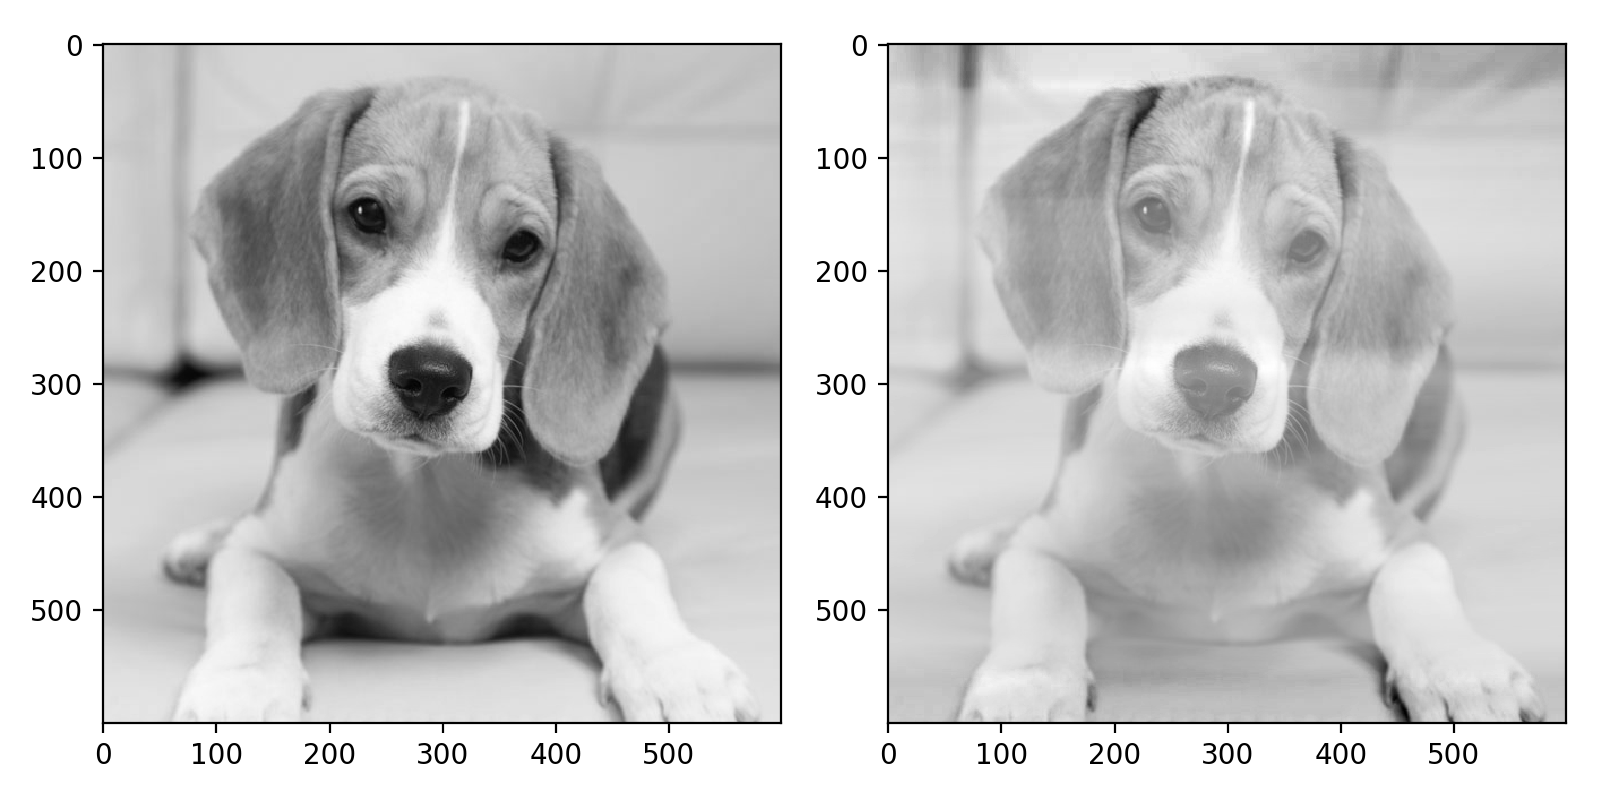

In [41]:
## This code cell will not be shown in the HTML version of this notebook
# load image
from PIL import Image
import matplotlib.gridspec as gridspec
image = Image.open('../../images/zca_images/dog.jpg').convert('L')

# contrast normalize
image_contrast_normalized = demo.contrast_normalize(image)

# plot images
fig = plt.figure(figsize=(8,4)); gs=gridspec.GridSpec(1,2)
fig.add_subplot(gs[0]); plt.imshow(image, cmap='gray')
fig.add_subplot(gs[1]); plt.imshow(image_contrast_normalized, cmap='gray')

<a id='unwanted-edges'></a>
## Introducing unwanted edges with typical input normalizers

In [this set of notes](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html) you can see how the simple idea of *standard normalizing* the input of a machine learning dataset could drastically improve the learning ability of a zero or first order local optimization technique by improving the contours of any associated cost function.  The natural evolution of this idea - [PCA sphering](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_5_PCA_sphereing.html) - can help even further improve the nature of a cost function, allowing for even easier learning.  

While there is nothing preventing us from applying standard normalization or PCA-based sphering to image-based data, doing so *destroys the natural spatial-correlation of image-based data* and thus much of the *edge information* in an image.  To get a sense of this we show the result of each input-normalization procedure applied to a large set of handwritten digits from the MNIST dataset - a random subset of which are shown below.

In [42]:
# This code cell will not be shown in the HTML version of this notebook
# load data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
x = MNIST.data.astype('float64')
y = np.reshape(MNIST.target, (-1, 1))
ind = np.random.permutation(len(y))
P = 70
x = x[ind[:P],:].T
y = y[ind[:P]]

<IPython.core.display.Javascript object>


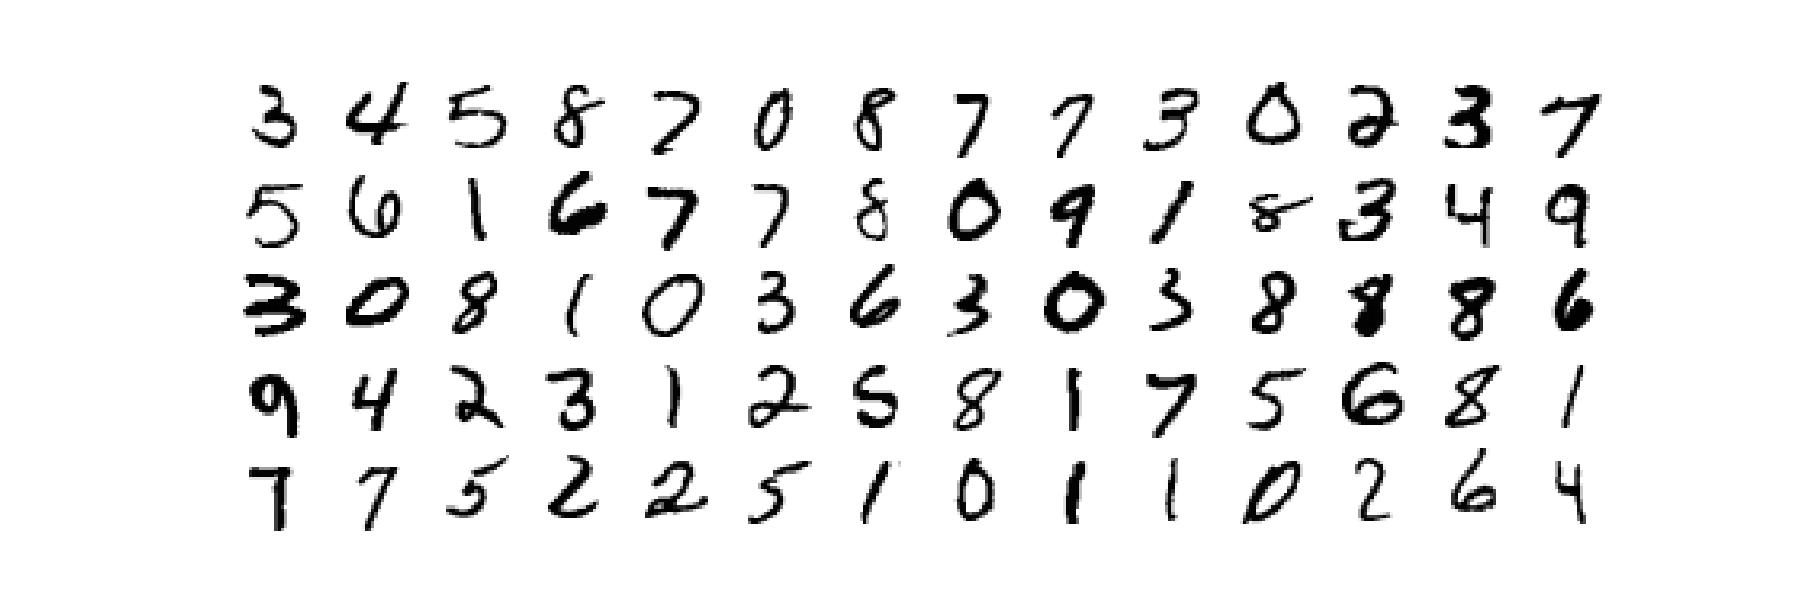

In [43]:
# This code cell will not be shown in the HTML version of this notebook
# plot a sample of the images
zcalib.visualizers.show_images(x)

Below we show the result of [*standard normalizing*](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html) a batch of these hand written digits - that is we normalize each feature (here each individual pixel) by mean centering and scaling by the standard deviation of all such pixels in the dataset.  Notice that while each digit is still identifiable, doing this *introduces* edge-based artifacts into these images which can make edge-based feature extractors (like a convolutional network) much less effective.

In [44]:
# This code cell will not be shown in the HTML version of this notebook
# standard normalize data
x_normalized = demo.standard_normalize(x)

<IPython.core.display.Javascript object>


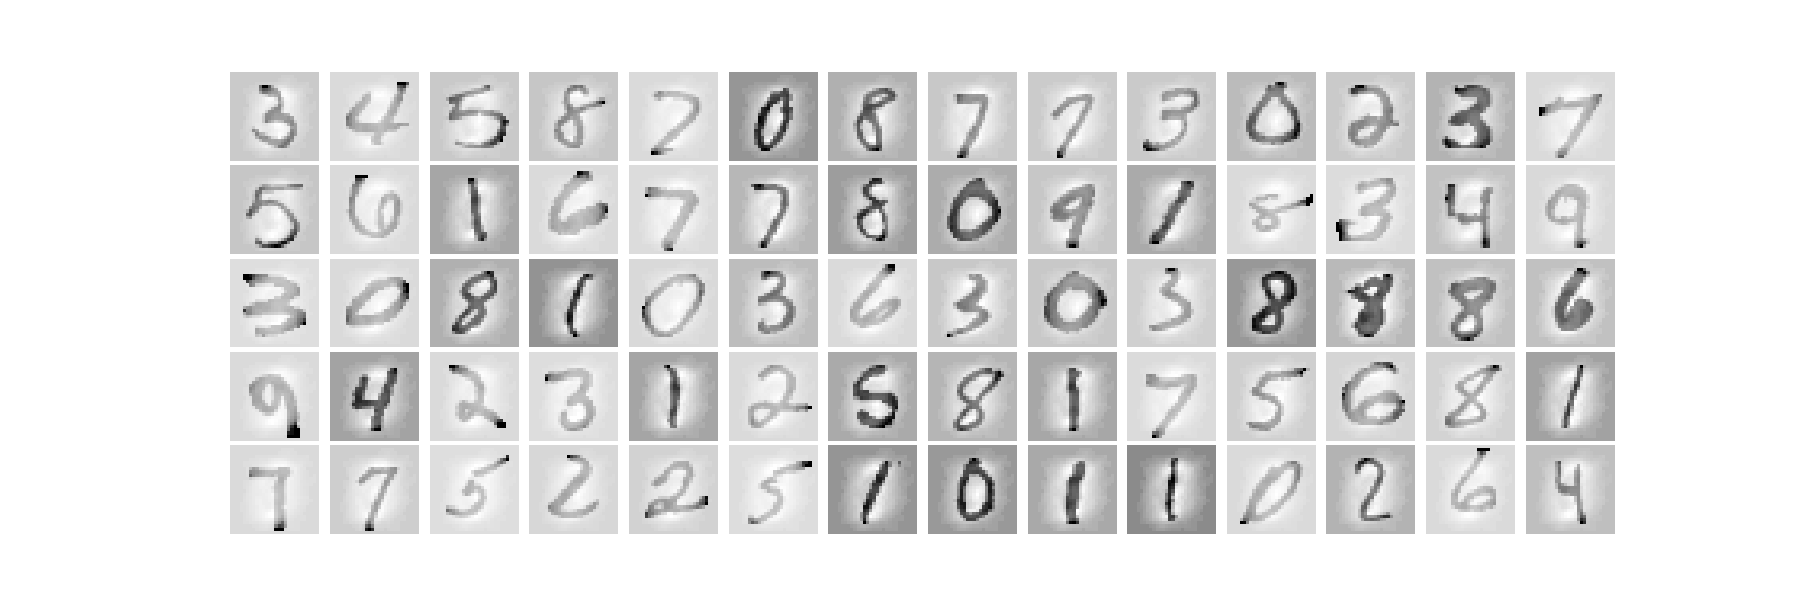

In [45]:
# This code cell will not be shown in the HTML version of this notebook
# plot standard-normalized data
zcalib.visualizers.show_images(x_normalized,cmap='gray')

Below we show the result of going one step further and [*PCA-sphering*](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_5_PCA_sphereing.html) this handwritten digit dataset, and plot a random subset of the resulting PCA-sphered data.  Note: these are the same images (transformed by the sphering process) we showed above.  

Here we can see that PCA-sphering completely destroys the spatial structure of the original images - none of the original numbers are visible in these transformed versions.  There is little point to using edge-based feature extractors (like a convolutional network) if there are no longer any (useful) edges in our images. 

In [46]:
# This code cell will not be shown in the HTML version of this notebook
# PCA-sphered
x_normalized = demo.PCA_sphere(x)

<IPython.core.display.Javascript object>


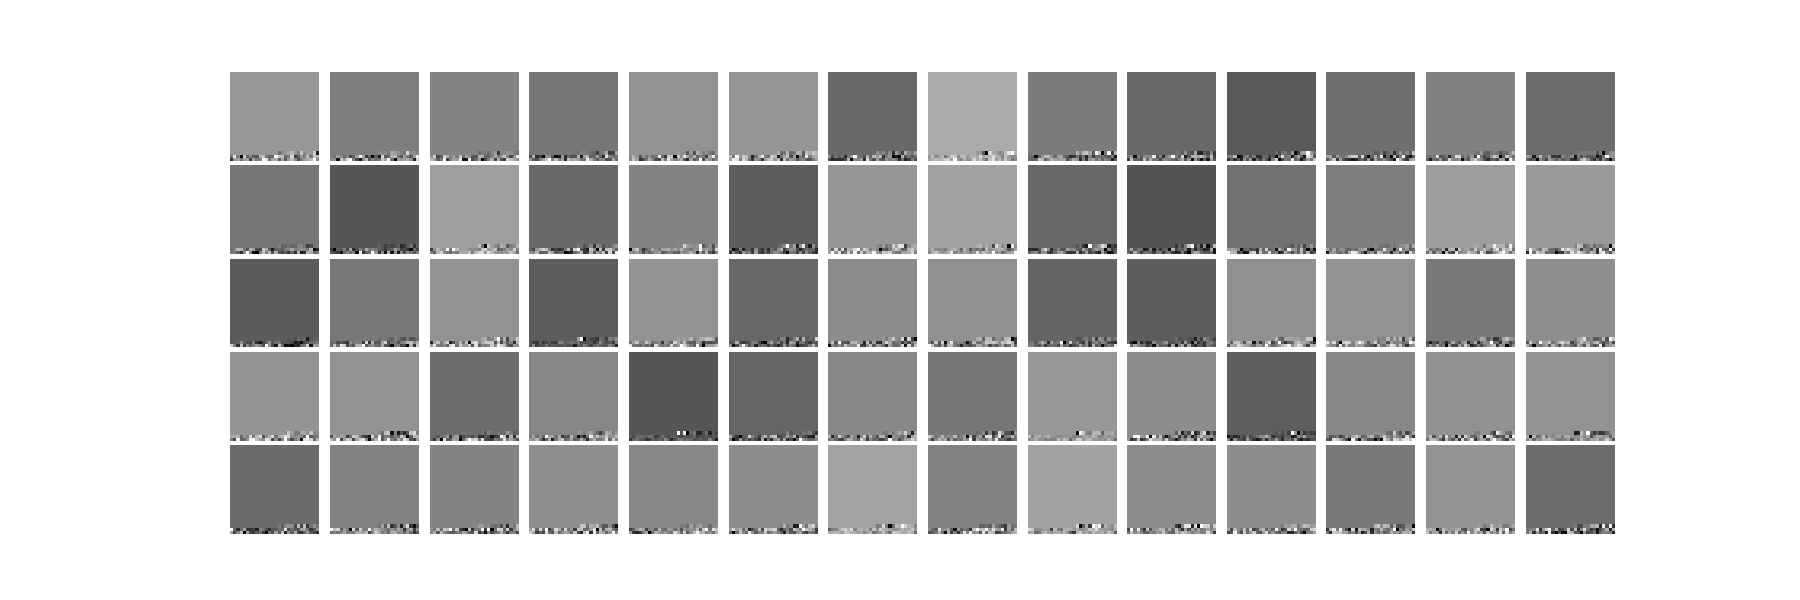

In [47]:
# This code cell will not be shown in the HTML version of this notebook
# plot PCA-sphered data
zcalib.visualizers.show_images(x_normalized)

<a id='PCA-sphereing'></a>
## What went wrong with PCA-sphering?

As detailed in the previous Example, in terms of the actions we perform on the data itself with PCA-sphering (or whitening) we:

- **rotate and reflect** by multiplying the data by $\mathbf{V}^T$ (where $\mathbf{V}$ is the set of eigenvectors of the data's covariance matrix) the data so that its largest orthogonal directions of variance align with the coordinate axes (this is done by the standard PCA transformation)

- **normalize** these coordinate axes by dividing by their individual standard deviations by multiplying the rotated/reflected data by $\mathbf{D}^{-^1/_2}$, the diagonal matrix of inverted square roots of the eigenvalues of the data's covariance matrix (this extra bit of normalization added to the PCA transformation to makes it the PCA-sphering operation)

Both of these actions contribute to the destruction of spatial correlation - but it is the **rotation / reflection** component that is by far the greater culprit.  We can get a visceral sense of this fact with our current dataset by simply applying the standard PCA transform - which will rotate / reflect the space so that the largest directions of variance coincide with the coordinate axes - without normalizing the result (which led to the PCA-sphering result above).   

<a id='ZCA-sphereing'></a>
## ZCA-sphering

The rotation / reflection from the PCA transformation utterly destroys the spatial correlation structure of our images, a phenomenon that is true more generally speaking for other image datasets as well.  What can we do if we would still like the added optimization-boosting benefit of PCA-sphering normalization but do not want to destroy the spatial correlation of our input data by rotating / reflecting it?  Well if indeed the rotation / reflection is producing the greatest challenge in terms of maintaining the spatial correlation of our data, why don't we simply rotate / reflect our dataset back to its original orientation after we finish sphering it (i.e.,normalizing it along its largest orthogonal directions of variance)?  Since we know that it multiplication by $\mathbf{V}^T$ that produces the original rotation / reflection, multiplying by PCA-sphered data by $\left(\mathbf{V}^T\right)^{-1} = \mathbf{V}^{\,}$ (where the equality follows from the fact that $\mathbf{V}$ is an orthogonal matrix) will return the sphered data to its original orientation in the space.  This is illustrated in the Figure below.

<figure>
  <img src= 'images/zca_sphereing.png' width="110%"  height="auto" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> ZCA-sphering illustrated. </em>  </figcaption> 
</figure>

Since our PCA-sphered transformation of the input data took the form $\mathbf{S}^{\,} =  \mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}$ this re-rotation/reflection gives us the related formula

\begin{equation}
\text{(ZCA-sphered data)}\,\,\,\,\,\,\,\,\, \mathbf{Z}^{\,} =  \mathbf{V}\mathbf{S} = \mathbf{V}\mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

For historical reasons this re-rotated version of our PCA-sphered data is often referred to as *Zero-phase Component Analysis (ZCA) sphering*. 

Below we show the result of ZCA-sphering our dataset.  What a difference!  Indeed it was the rotation/reflection of PCA that destroyed most of the spatial correlation, since these ZCA-sphered images retain much of the spatial correlation present in their original versions.  Now we have the best of both worlds: a global normalization scheme (that will help speed up training) that retains the spatial structure of data leveraged e.g., by edge detectors and convolution operations.

In [48]:
# This code cell will not be shown in the HTML version of this notebook
# PCA-sphered
x_normalized = demo.ZCA_sphere(x)

<IPython.core.display.Javascript object>


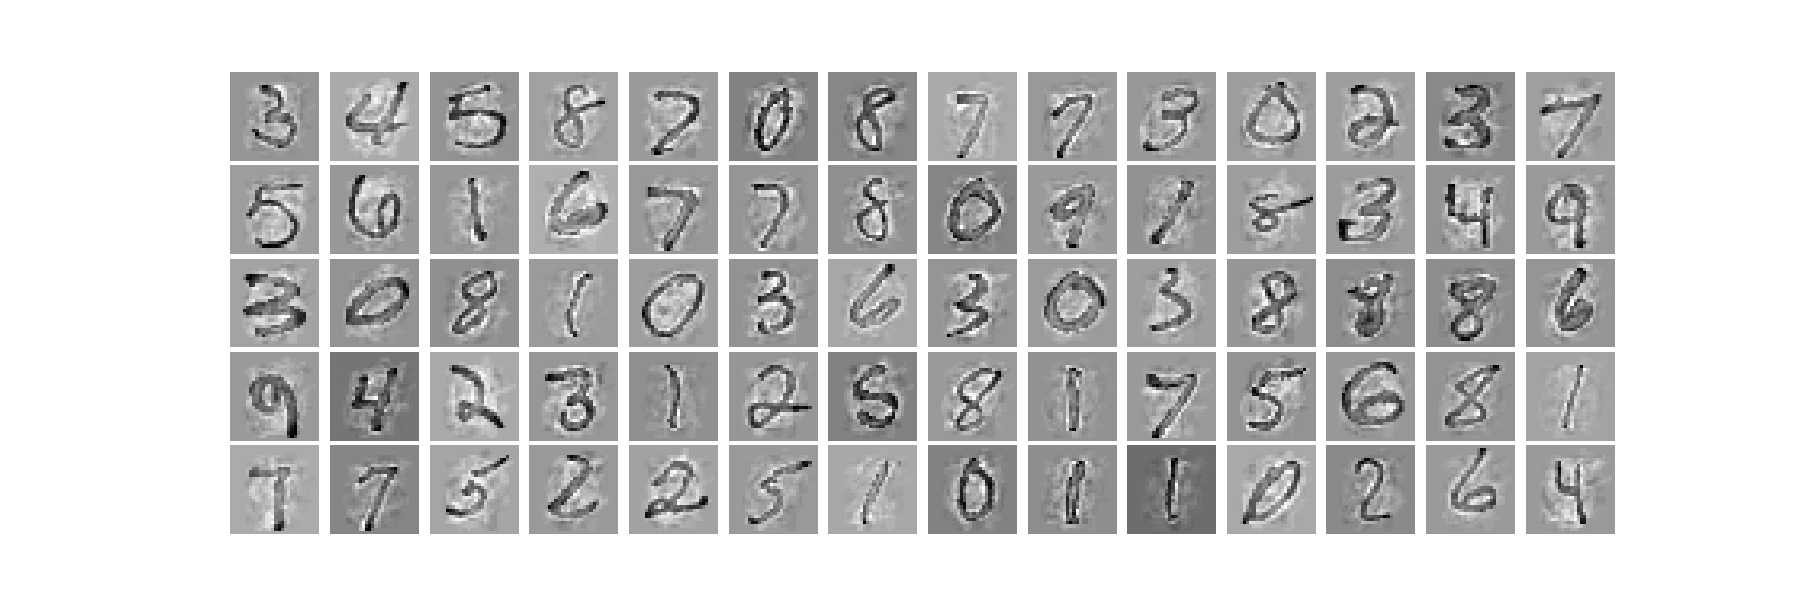

In [49]:
# This code cell will not be shown in the HTML version of this notebook
# plot PCA-sphered data
zcalib.visualizers.show_images(x_normalized,cmap='gray')

Just for kicks we show the same ZCA-sphered data below using a red-yellow-blue colormap.

<IPython.core.display.Javascript object>


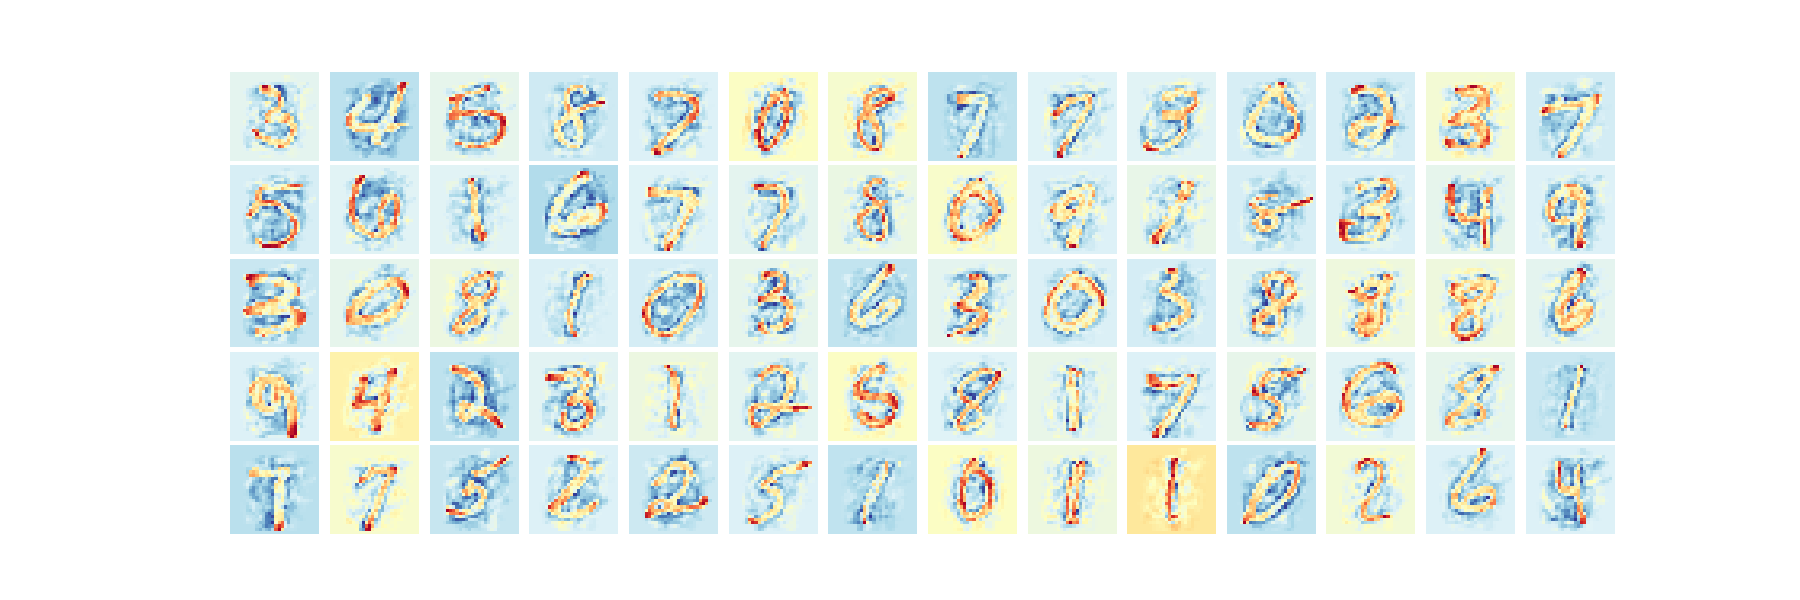

In [50]:
# This code cell will not be shown in the HTML version of this notebook
zcalib.visualizers.show_images(x_normalized,cmap='RdYlBu')

<a id='python-implementation'></a>
## Python implementation

Here we provide a simple implementation in `Python`.  We begin with a short `PCA` function for computing the principle components of an input data matrix `x`.  The interested reader can see [this set of notes on PCA](https://jermwatt.github.io/machine_learning_refined/notes/8_Linear_unsupervised_learning/8_5_Classic.html) for further details about this implementation.

In [ ]:
# sphereing pre-processing functionality 
def PCA(x,**kwargs):
    # regularization parameter for numerical stability
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # create the correlation matrix
    P = float(x.shape[1])
    Cov = 1/P*np.dot(x,x.T) + lam*np.eye(x.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    d,V = np.linalg.eigh(Cov)
    return d,V

Our `ZCA_spherer` below employs our `PCA` function in producing the required principal components.

In [ ]:
# ZCA spherer 
def ZCA_spherer(x,**kwargs):
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)

    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(stds < 10**(-5))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((stds.shape))
        adjust[ind] = 1.0
        stds += adjust

    # create normalizer / inverse-normalizer
    return np.dot(V,np.dot(V.T,x_centered)/stds)  